In [2]:
import json
import random
from pyjarowinkler import distance
import numpy as np

import os
# 使用第三张GPU卡
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
train=True
# 训练集中的作者论文信息
with open("train/train_author.json", "r") as f2:
    author_data = json.load(f2)

# 训练集的论文元信息
with open("train/train_pub.json", "r") as f2:
    pubs_dict = json.load(f2)

print(len(author_data))


name_train = set()

# 筛选训练集，只取同名作者数大于等于5个的名字作为训练集。
for name in author_data:
    persons = author_data[name]
    if(len(persons) > 5):
        name_train.add((name))

print(len(name_train))

# 采样500个训练例子，一个训练例子包含paper和正例作者以及5个负例作者（正负例比=1：5）

# 记录paper所属作者和名字
paper2aid2name = {}

for author_name in name_train:
    persons = author_data[author_name]
    for person in persons:
        paper_list = persons[person]
        for paper_id in paper_list:
            paper2aid2name[paper_id] = (author_name, person)

print(len(paper2aid2name))
# print(paper2aid2name)

total_paper_list = list(paper2aid2name.keys())

# 采样10000篇paper作为训练集
print(len(total_paper_list))
train_paper_list = random.sample(total_paper_list, 4000)

# train_paper_list = []
    
# 把采样的500篇paper转变成对应的训练例子，一个训练例子包含paper和正例作者以及5个负例作者（正负例比=1：5）
train_instances = []
for paper_id in train_paper_list:
    
    # 保存对应的正负例
    pos_ins = set()
    neg_ins = set()
    
    paper_author_name = paper2aid2name[paper_id][0]
    paper_author_id = paper2aid2name[paper_id][1]
    
    pos_ins.add((paper_id, paper_author_id))
    
    # 获取同名的所有作者(除了本身)作为负例的candidate
    persons = list(author_data[paper_author_name].keys())
    persons.remove(paper_author_id)
    assert len(persons) == (len(list(author_data[paper_author_name].keys())) - 1)
    
    # 每个正例采样5个负例
    neg_author_list = random.sample(persons, 5)
    for i in neg_author_list:
        neg_ins.add((paper_id, i))
        
    train_instances.append((pos_ins, neg_ins))
    
print(len(train_instances))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

待挖掘五维数据：

```python
a = len(set(keywords) & set(history_keywords))
b = a / len(set(keywords))
c = a / len(set(history_keywords))
d = len([x for x in keywords if x in (set(keywords)& set(history_keywords))])
e = d / len(history_keywords)
```

In [3]:
from pyjarowinkler import distance


# 对author_name 进行清洗
def clean_name(name):
    if name is None:
        return ""
    x = [k.strip() for k in name.lower().strip().replace(".", "").replace("-", " ").replace("_", ' ').split()]
    # x = [k.strip() for k in name.lower().strip().replace("-", "").replace("_", ' ').split()]
    full_name = ' '.join(x)
    name_part = full_name.split()
    if(len(name_part) >= 1):
        return full_name
    else:
        return None

# 找出paper中author_name所对应的位置
def delete_main_name(author_list, name):
    score_list = []
    name = clean_name(name)
    author_list_lower = []
    for author in author_list:
        author_list_lower.append(author.lower())
    name_split = name.split()
    for author in author_list_lower:
        # lower_name = author.lower()
        score = distance.get_jaro_distance(name, author, winkler=True, scaling=0.1)
        author_split = author.split()
        inter = set(name_split) & set(author_split)
        alls = set(name_split) | set(author_split)
        score += round(len(inter)/len(alls), 6)
        score_list.append(score)

    rank = np.argsort(-np.array(score_list))
    return_list = [author_list_lower[i] for i in rank[1:]]

    return return_list, rank[0]

# 训练集特征生成函数
def process_feature_coauthor(pos_ins, paper_coauthors):
    
    feature_list = []

    paper = pos_ins[0] 
    author = pos_ins[1]


    paper_name = paper2aid2name[paper][0]
    
    # 从作者的论文列表中把该篇论文去掉，防止训练出现bias
    doc_list = []
    for doc in author_data[paper_name][author]:
        if(doc != paper):
            doc_list.append(doc)
    for doc in doc_list:
        if doc == paper:
            print("error!")
            exit()
    
    # 保存作者的所有paper的coauthors名字以及各自出现的次数(作者所拥有论文的coauthors)
    candidate_authors_int = defaultdict(int)

    total_author_count = 0
    for doc in doc_list:
        
        doc_dict = pubs_dict[doc]
        author_list = []

        paper_authors = doc_dict['authors']
        paper_authors_len = len(paper_authors)
#         paper_authors = random.sample(paper_authors, min(50, paper_authors_len))
    
        for author in paper_authors:                
            clean_author = clean_name(author['name'])
            if(clean_author != None):
                author_list.append(clean_author)
        if(len(author_list) > 0):
            # 获取paper中main author_name所对应的位置
            _, author_index = delete_main_name(author_list, paper_name)

            # 获取除了main author_name外的coauthor
            for index in range(len(author_list)):
                if(index == author_index):
                    continue
                else:
                    candidate_authors_int[author_list[index]] += 1
                    total_author_count += 1

    # author 的所有不同coauthor name
    author_keys = list(candidate_authors_int.keys())

    if ((len(author_keys) == 0) or (len(paper_coauthors) == 0)):
        feature_list.extend([0.] * 5)
    else:
        co_coauthors = set(paper_coauthors) & set(author_keys)
        coauthor_len = len(co_coauthors)  # paper中曾经合作者个数
        
        
        co_coauthors_ratio_for_paper = round(coauthor_len / len(paper_coauthors), 6)  # paper中曾经合作者占paper所有合作者比例
        co_coauthors_ratio_for_author = round(coauthor_len / len(author_keys), 6)  # paper中曾经合作者占所有曾经合作者比例
        
        coauthor_count = 0  # 所有曾经合作者出现总人次
        for coauthor_name in co_coauthors:
            coauthor_count += candidate_authors_int[coauthor_name]
            
        
        
        co_coauthors_ratio_for_author_count = round(coauthor_count / total_author_count, 6)  # 所有曾经合作者出现总人次占所有paper所有合作者人次比例

        # 计算了5维paper与author所有的paper的coauthor相关的特征：
        #    1. 不重复的coauthor个数
        #    2. 不重复的coauthor个数 / paper的所有coauthor的个数
        #    3. 不重复的coauthor个数 / author的所有paper不重复coauthor的个数
        #    4. coauthor个数（含重复）
        #    4. coauthor个数（含重复）/ author的所有paper的coauthor的个数（含重复）
        feature_list.extend([coauthor_len, co_coauthors_ratio_for_paper, co_coauthors_ratio_for_author, coauthor_count, co_coauthors_ratio_for_author_count])
        
#         print(feature_list)
    return feature_list

In [4]:
def process_feature_keywords(pos_ins, topic_list):
    
    feature_list = []

    paper = pos_ins[0] 
    author = pos_ins[1]


    paper_name = paper2aid2name[paper][0]
    
    # 从作者的论文列表中把该篇论文去掉，防止训练出现bias
    doc_list = []
    for doc in author_data[paper_name][author]:
        if(doc != paper):
            doc_list.append(doc)
    for doc in doc_list:
        if doc == paper:
            print("error!")
            exit()
    
    # 保存作者的所有paper的coauthors以及各自出现的次数(作者所拥有论文的coauthors)
    candidate_keywords_int = defaultdict(int)

    total_keyword_count = 0
    for doc in doc_list:
        
        doc_dict = pubs_dict[doc]
        keyword_list = []
        if ('keywords' not in doc_dict.keys()):
            feature_list.extend([0.] * 5)
            return feature_list
        paper_keywords = doc_dict['keywords']
        paper_keywords_len = len(paper_keywords)
        paper_keywords = random.sample(paper_keywords, min(10, paper_keywords_len))
        
        for keywords in paper_keywords:
            clean_keywords=clean_name(keywords)
            if clean_keywords!=None:
                keyword_list.append(clean_keywords)
        if(len(keyword_list) > 0):
            # 获取除了main author_name外的coauthor
            for index in range(len(keyword_list)):
                candidate_keywords_int[keyword_list[index]] += 1
                total_keyword_count += 1

    # author 的所有不同coauthor name
    author_keys = list(candidate_keywords_int.keys())

    if ((len(author_keys) == 0) or (len(paper_keywords) == 0)):
        feature_list.extend([0.] * 5)
    else:
        co_keywords = set(paper_keywords) & set(author_keys)
        keyword_len = len(co_keywords)
#         same=[x for x in paper_keywords if  x in author_keys]
        co_keywords_ratio_for_paper = round(keyword_len / len(paper_keywords), 6)
        co_keywords_ratio_for_author = round(keyword_len / len(author_keys), 6)
        
        keywords_count = 0
        for keywords_name in co_keywords:
            keywords_count += candidate_keywords_int[keywords_name]
            
        
        
        co_keywords_ratio_for_author_count = round(keywords_count / total_keyword_count, 6)

        
        feature_list.extend([keyword_len, co_keywords_ratio_for_paper, co_keywords_ratio_for_paper, keywords_count, co_keywords_ratio_for_author_count])
        
#         print(feature_list)
    return feature_list

In [5]:
import tqdm
from collections import defaultdict

pos_features_author = []
neg_features_author = []
pos_features_keywords = []
neg_features_keywords = []
pos_features_org = []
neg_features_org = []
print(len(train_instances))

for ins in tqdm.tqdm(train_instances):
    
    pos_set = ins[0]
    neg_set = ins[1]
    paper_id = list(pos_set)[0][0]
    paper_name = paper2aid2name[paper_id][0]
    author_name=None
    
    author_list = []
    # 获取paper的coauthors
    paper_coauthors = []
    feature_coauthor=[]
    
    paper_authors = pubs_dict[paper_id]['authors']
    paper_authors_len = len(paper_authors)
    # 只取前50个author以保证效率
#     paper_authors = random.sample(paper_authors, min(50, paper_authors_len))

    for author in paper_authors:                
        clean_author = clean_name(author['name'])
#         print(author['name'],clean_author)
        if(clean_author != None):
            author_list.append(clean_author)
    if(len(author_list) > 0):
        # 获取paper中main author_name所对应的位置
        _, author_index = delete_main_name(author_list, paper_name)
        
        # 获取除了main author_name外的coauthor
        for index in range(len(author_list)):
            if(index == author_index):
                author_name=author_list[author_index]
                continue
            else:
                paper_coauthors.append(author_list[index])
        
    
        for pos_ins in pos_set:
            pos_features_author.append(process_feature_coauthor(pos_ins, paper_coauthors))
    
        for neg_ins in neg_set:
            neg_features_author.append(process_feature_coauthor(neg_ins, paper_coauthors))
    else:
        for pos_ins in pos_set:
            pos_features_author.append([0.] * 5)
    
        for neg_ins in neg_set:
            neg_features_author.append([0.] * 5)
        
#         处理话题
    topic_list=[]
    if 'keywords' in pubs_dict[paper_id].keys():
        paper_topics=pubs_dict[paper_id]['keywords']
    
    paper_topics_len=len(paper_topics)
    paper_topics=random.sample(paper_topics,min(10,paper_topics_len))
    for topic in paper_topics:
        clean_topic=clean_name(topic)
#         print(topic,clean_topic)
        if clean_topic!=None:
            topic_list.append(clean_topic)
    if len(topic_list)>0:
        for pos_ins in pos_set:
            pos_features_keywords.append(process_feature_keywords(pos_ins,topic_list))
        for neg_ins in neg_set:
            neg_features_keywords.append(process_feature_keywords(neg_ins,topic_list))
    else:
        for pos_ins in pos_set:
            pos_features_keywords.append([0.] * 5)
        for neg_ins in neg_set:
            neg_features_keywords.append([0.] * 5)

pos_features=[]
neg_features=[]
for i in range(len(pos_features_author)):
    pos_features.append(pos_features_author[i]+pos_features_keywords[i])
for i in range(len(neg_features_author)):
    neg_features.append(neg_features_author[i]+neg_features_keywords[i])

40000


100%|██████████| 40000/40000 [2:29:46<00:00,  4.45it/s]   


In [6]:
# np.savetxt("pos_features.txt",pos_features,fmt='%f',delimiter=',' )
# np.savetxt("neg_features.txt",neg_features,fmt='%f',delimiter=',')

In [3]:
pos_features= np.loadtxt('pos_features.txt',delimiter=',')
neg_features= np.loadtxt('neg_features.txt',delimiter=',')

In [4]:
neg_features.shape

(993035, 10)

In [3]:
pos_features.shape

(198607, 10)

In [15]:
np.array(train_ins)[:, 1]

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [29]:
model = None
train_ins = []
train_ins.extend([(ins.tolist(), 1) for ins in pos_features])
train_ins.extend([(ins.tolist(), 0) for ins in neg_features])
# train_ins = np.array(train_ins)
# print(train_ins.shape)

random.shuffle(train_ins)

x_train = [x for (x, y) in train_ins]
y_train = [y for (x, y) in train_ins]

In [31]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
yy = [[0],[1]]
encoder.fit(yy)
y_train_reshape = np.array(y_train).reshape(-1,1)
y_train_onehot = encoder.transform(y_train_reshape)
print(y_train_onehot[1:10])

# y_test_reshape=np.array(y_test).reshape(-1,1)
# y_test_onehot=encoder.transform(y_test_reshape)
# print(y_test_onehot[1:10]
x_train = np.array(x_train)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [21]:
# import tensorflow as tf
import keras
import pickle as p
import os
# logdir="logs"
# checkpoint_path='./checkpoint/author.{epoch:02d}-{val_loss:.2f}.ckpt'
callbacks=[
#     keras.callbacks.TensorBoard(log_dir=logdir,
#                                    histogram_freq=2),  # 生成tb需要的日志
#     keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                       save_weights_only=True,
#                                       verbose=1,
#                                       period=5),  # 用于在epoch间保存要模型
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=3, 
                                         verbose=1, 
                                         mbode='auto', 
                                         epsilon=0.0001, 
                                         cooldown=0, 
                                         min_lr=0),  # 当指标变化小时，减少学习率
]
# checkpoint_dir=os.path.dirname(checkpoint_path)
# latest=tf.train.latest_checkpoint(checkpoint_dir)

Using TensorFlow backend.
/home/zengrui/miniconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [38]:
#建立Keras序列模型
model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization(input_shape=(10,)))
model.add(keras.layers.Dense(units=512,
                               input_dim=10,
                               use_bias=True,
                               kernel_initializer='uniform',
                               bias_initializer='zeros',
                               activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=256,
                               activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=128,
                               activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=64,
                               activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=16,
                               activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=2,
                                activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(0.1),    
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [39]:
#if latest:
#    model.load_weights(latest)
# if train:    
train_history = model.fit(x=x_train,
                        shuffle=True,
                        y=y_train_onehot,
                        validation_split=0.2,  # 0.2用作验证集
                        epochs=30,
                        batch_size=8192,
                        callbacks=callbacks,
                        verbose=1) 

Train on 953313 samples, validate on 238329 samples
Epoch 1/30
953313/953313 [==============================] - 4s 4us/step - loss: 0.1372 - accuracy: 0.9623 - val_loss: 0.4140 - val_accuracy: 0.8128
Epoch 2/30
953313/953313 [==============================] - 3s 3us/step - loss: 0.1182 - accuracy: 0.9720 - val_loss: 0.1282 - val_accuracy: 0.9721
Epoch 3/30
953313/953313 [==============================] - 3s 3us/step - loss: 0.1176 - accuracy: 0.9721 - val_loss: 0.3888 - val_accuracy: 0.9715
Epoch 4/30
953313/953313 [==============================] - 3s 3us/step - loss: 0.1174 - accuracy: 0.9722 - val_loss: 0.1161 - val_accuracy: 0.9724
Epoch 5/30
953313/953313 [==============================] - 3s 3us/step - loss: 0.1169 - accuracy: 0.9723 - val_loss: 0.1205 - val_accuracy: 0.9724
Epoch 6/30
953313/953313 [==============================] - 3s 3us/step - loss: 0.1171 - accuracy: 0.9722 - val_loss: 0.1183 - val_accuracy: 0.9721
Epoch 7/30
953313/953313 [==============================] - 

In [51]:
from collections import Counter
Counter(y_train)

Counter({0: 993035, 1: 198607})

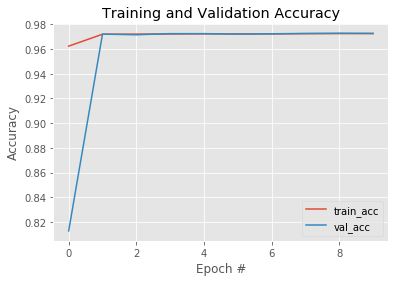

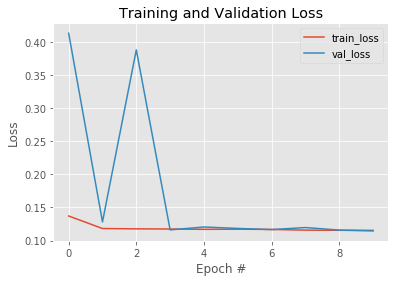

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线
H = train_history

N = np.arange(0, 10)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"][:10], label="train_acc")
plt.plot(N, H.history["val_accuracy"][:10], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_acc.png')
 
plt.figure()
plt.plot(N, H.history["loss"][:10], label="train_loss")
plt.plot(N, H.history["val_loss"][:10], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),    
             loss='binary_crossentropy',
             metrics=['accuracy'])
#if latest:
#    model.load_weights(latest)
if train:    
    train_history=model.fit(x=x_train,
                            shuffle=True,
                            y=y_train_onehot,
                            validation_split=0.1,  # 0.2用作验证集
                            epochs=5,
                            batch_size=2048,
                            callbacks=callbacks,
                            verbose=1) 

Train on 216000 samples, validate on 24000 samples
Epoch 1/5
216000/216000 [==============================] - 4s 19us/sample - loss: 0.1138 - accuracy: 0.9732 - val_loss: 0.1140 - val_accuracy: 0.9728
Epoch 2/5
216000/216000 [==============================] - 2s 11us/sample - loss: 0.1137 - accuracy: 0.9732 - val_loss: 0.1140 - val_accuracy: 0.9728
Epoch 3/5
216000/216000 [==============================] - 2s 11us/sample - loss: 0.1138 - accuracy: 0.9732 - val_loss: 0.1140 - val_accuracy: 0.9728
Epoch 4/5
216000/216000 [==============================] - 2s 11us/sample - loss: 0.1138 - accuracy: 0.9732 - val_loss: 0.1140 - val_accuracy: 0.9728
Epoch 5/5
212992/216000 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9732
Epoch 00005: saving model to ./checkpoint/author.05-0.11.ckpt
216000/216000 [==============================] - 2s 11us/sample - loss: 0.1137 - accuracy: 0.9732 - val_loss: 0.1140 - val_accuracy: 0.9728


In [29]:
# 训练集中的作者论文信息
with open("cna_data/whole_author_profile.json", "r") as f2:
    test_author_data = json.load(f2)

# 训练集的论文元信息
with open("cna_data/whole_author_profile_pub.json", "r") as f2:
    test_pubs_dict = json.load(f2)

# 待分配论文集
with open("cna_test_data/cna_test_unass_competition.json", "r") as f2:
    unass_papers = json.load(f2)

with open("cna_test_data/cna_test_pub.json", "r") as f2:
    unass_papers_dict = json.load(f2)
name_list=[]
# with open("cna_data/new_test_author_data.json", 'r') as files:
#     new_test_author_data = json.load(files)
# 简单处理whole_author_profile，将同名的作者合并：
# 为了效率，预处理new_test_author_data中的paper，将其全部处理成paper_id + '-' + author_index的形式。
new_test_author_data = {}
for author_id, author_info in tqdm.tqdm(test_author_data.items()):
    author_name = author_info['name']
    author_papers = author_info['papers']
    newly_papers = []

    for paper_id in author_papers:

        paper_authors = test_pubs_dict[paper_id]['authors']
        paper_authors_len = len(paper_authors)
        
        # 只利用author数小于50的paper，以保证效率
        if(paper_authors_len > 50):
            continue
#         paper_authors = random.sample(paper_authors, min(50, paper_authors_len))
        author_list = []
        for author in paper_authors:                
            clean_author = clean_name(author['name'])
            if(clean_author != None):
                author_list.append(clean_author)
        if(len(author_list) > 0):
            # 获取paper中main author_name所对应的位置
            _, author_index = delete_main_name(author_list, author_name)
#             print(paper_name)
            new_paper_id = str(paper_id) + '-' + str(author_index)
            newly_papers.append(new_paper_id)
            
       
        
        
    if(new_test_author_data.get(author_name) != None):
        new_test_author_data[author_name][author_id] = newly_papers
    else:
        tmp = {}
        tmp[author_id] = newly_papers
        new_test_author_data[author_name] = tmp
        name_list.append(author_name)
print(len(new_test_author_data))


 69%|██████▉   | 17941/25911 [00:37<00:15, 522.15it/s]


100%|██████████| 25911/25911 [00:56<00:00, 462.11it/s]

320


In [30]:
# test集的特征生成函数，与train类似
def process_test_feature_coauthor(pair, new_test_author_data, test_pubs_dict, paper_coauthors):
    
    feature_list = []

    paper = pair[0] 
    author = pair[1]
    paper_name = pair[2]
    
    doc_list = new_test_author_data[paper_name][author]

    
    # 保存作者的所有coauthors以及各自出现的次数(作者所拥有论文的coauthors)
    candidate_authors_int = defaultdict(int)

    total_author_count = 0
    for doc in doc_list:
        doc_id = doc.split('-')[0]
        author_index = doc.split('-')[1]
        doc_dict = test_pubs_dict[doc_id]
        author_list = []

        paper_authors = doc_dict['authors']
        paper_authors_len = len(paper_authors)
        paper_authors = random.sample(paper_authors, min(50, paper_authors_len))
    
        for author in paper_authors:                
            clean_author = clean_name(author['name'])
            if(clean_author != None):
                author_list.append(clean_author)
        if(len(author_list) > 0):

            # 获取除了main author_name外的coauthor
            for index in range(len(author_list)):
                if(index == author_index):
                    continue
                else:
                    candidate_authors_int[author_list[index]] += 1
                    total_author_count += 1

    author_keys = list(candidate_authors_int.keys())

    if ((len(author_keys) == 0) or (len(paper_coauthors) == 0)):
        feature_list.extend([0.] * 5)
    else:
        co_coauthors = set(paper_coauthors) & set(author_keys)
        coauthor_len = len(co_coauthors)
        
        co_coauthors_ratio_for_paper = round(coauthor_len / len(paper_coauthors), 6)
        co_coauthors_ratio_for_author = round(coauthor_len / len(author_keys), 6)
        
        coauthor_count = 0
        for coauthor_name in co_coauthors:
            coauthor_count += candidate_authors_int[coauthor_name]
            
        
        
        co_coauthors_ratio_for_author_count = round(coauthor_count / total_author_count, 6)

        # 计算了5维paper与author所有的paper的coauthor相关的特征：
        #    1. 不重复的coauthor个数
        #    2. 不重复的coauthor个数 / paper的所有coauthor的个数
        #    3. 不重复的coauthor个数 / author的所有paper不重复coauthor的个数
        #    4. coauthor个数（含重复）
        #    4. coauthor个数（含重复）/ author的所有paper的coauthor的个数（含重复）
        feature_list.extend([coauthor_len, co_coauthors_ratio_for_paper, co_coauthors_ratio_for_author, coauthor_count, co_coauthors_ratio_for_author_count])
        
#         print(feature_list)
    return feature_list

In [31]:
# test集的特征生成函数，与train类似
def process_test_feature_keywords(pair, new_test_author_data, test_pubs_dict, paper_coauthors):
    
    feature_list = []

    paper = pair[0] 
    author = pair[1]
    paper_name = pair[2]
    
    doc_list = new_test_author_data[paper_name][author]

    
    # 保存作者的所有coauthors以及各自出现的次数(作者所拥有论文的coauthors)
    candidate_authors_int = defaultdict(int)

    total_author_count = 0
    for doc in doc_list:
        doc_id = doc.split('-')[0]
        author_index = doc.split('-')[1]
        doc_dict = test_pubs_dict[doc_id]
        author_list = []
        
        if 'keywords' not in doc_dict.keys():
            continue
        paper_authors = doc_dict['keywords']
        paper_authors_len = len(paper_authors)
        paper_authors = random.sample(paper_authors, min(10, paper_authors_len))
    
        for author in paper_authors:                
            author_list.append(author)
        if(len(author_list) > 0):

            # 获取除了main author_name外的coauthor
            for index in range(len(author_list)):
                if(index == author_index):
                    continue
                else:
                    candidate_authors_int[author_list[index]] += 1
                    total_author_count += 1
    author_keys = list(candidate_authors_int.keys())

    if ((len(author_keys) == 0) or (len(paper_coauthors) == 0)):
        feature_list.extend([0.] * 5)
    else:
        co_coauthors = set(paper_coauthors) & set(author_keys)
        coauthor_len = len(co_coauthors)
#         print(coauthor_len)
        co_coauthors_ratio_for_paper = round(coauthor_len / len(paper_coauthors), 6)
        co_coauthors_ratio_for_author = round(coauthor_len / len(author_keys), 6)
        
        coauthor_count = 0
        for coauthor_name in co_coauthors:
            coauthor_count += candidate_authors_int[coauthor_name]
            
        
        
        co_coauthors_ratio_for_author_count = round(coauthor_count / total_author_count, 6)

        # 计算了5维paper与author所有的paper的coauthor相关的特征：
        #    1. 不重复的coauthor个数
        #    2. 不重复的coauthor个数 / paper的所有coauthor的个数
        #    3. 不重复的coauthor个数 / author的所有paper不重复coauthor的个数
        #    4. coauthor个数（含重复）
        #    4. coauthor个数（含重复）/ author的所有paper的coauthor的个数（含重复）
        feature_list.extend([coauthor_len, co_coauthors_ratio_for_paper, co_coauthors_ratio_for_author, coauthor_count, co_coauthors_ratio_for_author_count])
        
#         print(feature_list)
    return feature_list

In [40]:
print(len(unass_papers))


count = 0

# 存储paper的所有candidate author id
paper2candidates = defaultdict(list)
# 存储对应的paper与candidate author的生成特征
paper2features = defaultdict(list)

for u_p in tqdm.tqdm(unass_papers):
    paper_id = u_p.split('-')[0]
    author_index = int(u_p.split('-')[1])
    author_list = []
    
    # 获取paper的coauthors
    paper_coauthors = []
    keywords_list=[]
    paper_name = ''
    paper_authors = unass_papers_dict[paper_id]['authors']
    if 'keywords' in unass_papers_dict[paper_id].keys():
        paper_keywords=unass_papers_dict[paper_id]['keywords']
    else:
        paper_keywords=''
    author_name=''
    org=''
#     paper_authors_len = len(paper_authors)
#     paper_authors = random.sample(paper_authors, min(50, paper_authors_len))

    for author in paper_authors:                
        clean_author = clean_name(author['name'])
        if(clean_author != None):
            author_list.append(clean_author)
    for key in paper_keywords:
        clean_key=clean_name(key)
        if clean_key!=None:
            keywords_list.append(clean_key)
    if(len(author_list) > 0):
        
        # 获取除了main author_name外的coauthor
        for index in range(len(author_list)):
            if(index == author_index):
                author_name=author_list[author_index]
                continue
            else:
                paper_coauthors.append(author_list[index])
    for author in paper_authors:
#         print(author.keys())
        clean_author = clean_name(author['name'])
        
        if author_name==clean_author and 'org' in author.keys():
            org=author['org']
#             print('in')
            
# 简单使用精确匹配找出candidate_author_list
   

    if paper_authors[author_index]['name'] == None or paper_authors[author_index]['name']==' ':
        paper_name=' '
    else:
        paper_name = '_'.join(clean_name(paper_authors[author_index]['name']).split())
    if(new_test_author_data.get(paper_name) != None):
        candidate_author_list = new_test_author_data[paper_name]
        for candidate_author in candidate_author_list:
            pair = (paper_id, candidate_author, paper_name)
            paper2candidates[paper_id].append(candidate_author)
            paper2features[paper_id].append(process_test_feature_coauthor(pair, new_test_author_data, test_pubs_dict, paper_coauthors)+
                                            process_test_feature_keywords(pair, new_test_author_data, test_pubs_dict, paper_keywords))
        count += 1
    else:
        score=0.0
        name_index=' '
        for name in (name_list):
            name_split=name.split('_')
            temp = distance.get_jaro_distance(paper_name, name, winkler=True, scaling=0.1)
            pname_split = paper_name.split('_')
            inter = set(name_split) & set(pname_split)
            alls = set(name_split) | set(pname_split)
            temp += round(len(inter)/len(alls), 6)
            if score<temp:
                name_index=name
                score=temp
        if(new_test_author_data.get(name_index) != None):
            candidate_author_list = new_test_author_data[name_index]
            for candidate_author in candidate_author_list:
                pair = (paper_id, candidate_author, name_index)
                paper2candidates[paper_id].append(candidate_author)
                paper2features[paper_id].append(process_test_feature_coauthor(pair, new_test_author_data, test_pubs_dict, paper_coauthors)+
                                            process_test_feature_keywords(pair, new_test_author_data, test_pubs_dict, paper_keywords))
                
            count+=1
            
            
print(count)
assert len(paper2candidates) == len(paper2features)
print(len(paper2candidates))




  0%|          | 0/9650 [00:00<?, ?it/s]

9650





  0%|          | 6/9650 [00:00<05:18, 30.24it/s]


  0%|          | 11/9650 [00:00<04:56, 32.50it/s]


  0%|          | 13/9650 [00:00<06:33, 24.48it/s]


  0%|          | 18/9650 [00:00<06:18, 25.42it/s]


  0%|          | 23/9650 [00:00<05:49, 27.58it/s]


  0%|          | 27/9650 [00:00<05:24, 29.64it/s]


  0%|          | 30/9650 [00:01<05:55, 27.08it/s]


  0%|          | 33/9650 [00:01<06:33, 24.43it/s]


  0%|          | 36/9650 [00:01<07:30, 21.36it/s]


  0%|          | 40/9650 [00:01<07:03, 22.69it/s]


  0%|          | 43/9650 [00:01<07:17, 21.93it/s]


  0%|          | 46/9650 [00:01<07:02, 22.71it/s]


  1%|          | 49/9650 [00:01<06:34, 24.31it/s]


  1%|          | 52/9650 [00:02<07:25, 21.55it/s]


  1%|          | 56/9650 [00:02<06:27, 24.77it/s]


  1%|          | 59/9650 [00:02<07:05, 22.57it/s]


  1%|          | 62/9650 [00:02<06:38, 24.07it/s]


  1%|          | 67/9650 [00:02<06:01, 26.50it/s]


  1%|          | 70/9650 [00:02<05:51, 27.22it/s]


  1%|     

 12%|█▏        | 1137/9650 [00:38<04:58, 28.53it/s]


 12%|█▏        | 1141/9650 [00:38<04:55, 28.84it/s]


 12%|█▏        | 1147/9650 [00:38<04:30, 31.44it/s]


 12%|█▏        | 1151/9650 [00:39<04:51, 29.14it/s]


 12%|█▏        | 1155/9650 [00:39<04:58, 28.42it/s]


 12%|█▏        | 1159/9650 [00:39<05:03, 27.97it/s]


 12%|█▏        | 1162/9650 [00:39<05:23, 26.23it/s]


 12%|█▏        | 1168/9650 [00:39<04:29, 31.46it/s]


 12%|█▏        | 1173/9650 [00:39<04:27, 31.73it/s]


 12%|█▏        | 1180/9650 [00:39<04:04, 34.58it/s]


 12%|█▏        | 1184/9650 [00:40<03:59, 35.37it/s]


 12%|█▏        | 1188/9650 [00:40<04:11, 33.59it/s]


 12%|█▏        | 1192/9650 [00:40<04:29, 31.39it/s]


 12%|█▏        | 1198/9650 [00:40<03:52, 36.30it/s]


 12%|█▏        | 1203/9650 [00:40<04:30, 31.18it/s]


 13%|█▎        | 1207/9650 [00:40<06:00, 23.43it/s]


 13%|█▎        | 1212/9650 [00:40<05:10, 27.17it/s]


 13%|█▎        | 1218/9650 [00:41<04:20, 32.39it/s]


 13%|█▎        | 1224/9650 [

 23%|██▎       | 2256/9650 [01:16<03:39, 33.64it/s]


 23%|██▎       | 2261/9650 [01:17<03:42, 33.19it/s]


 23%|██▎       | 2265/9650 [01:17<04:05, 30.11it/s]


 24%|██▎       | 2269/9650 [01:17<04:02, 30.46it/s]


 24%|██▎       | 2273/9650 [01:17<04:25, 27.83it/s]


 24%|██▎       | 2277/9650 [01:17<05:00, 24.54it/s]


 24%|██▎       | 2280/9650 [01:17<05:04, 24.21it/s]


 24%|██▎       | 2286/9650 [01:18<04:14, 28.88it/s]


 24%|██▎       | 2291/9650 [01:18<03:43, 32.98it/s]


 24%|██▍       | 2295/9650 [01:18<03:32, 34.59it/s]


 24%|██▍       | 2299/9650 [01:18<03:45, 32.63it/s]


 24%|██▍       | 2303/9650 [01:18<03:35, 34.13it/s]


 24%|██▍       | 2311/9650 [01:18<02:59, 40.78it/s]


 24%|██▍       | 2316/9650 [01:18<03:07, 39.10it/s]


 24%|██▍       | 2321/9650 [01:18<02:55, 41.78it/s]


 24%|██▍       | 2326/9650 [01:18<03:00, 40.60it/s]


 24%|██▍       | 2331/9650 [01:19<03:37, 33.59it/s]


 24%|██▍       | 2336/9650 [01:19<03:19, 36.75it/s]


 24%|██▍       | 2341/9650 [

 35%|███▌      | 3421/9650 [01:55<03:45, 27.57it/s]


 36%|███▌      | 3426/9650 [01:55<03:30, 29.61it/s]


 36%|███▌      | 3430/9650 [01:55<03:32, 29.31it/s]


 36%|███▌      | 3434/9650 [01:56<03:49, 27.11it/s]


 36%|███▌      | 3438/9650 [01:56<03:56, 26.23it/s]


 36%|███▌      | 3442/9650 [01:56<03:50, 26.89it/s]


 36%|███▌      | 3445/9650 [01:56<04:57, 20.85it/s]


 36%|███▌      | 3449/9650 [01:56<04:39, 22.17it/s]


 36%|███▌      | 3452/9650 [01:56<04:29, 22.98it/s]


 36%|███▌      | 3455/9650 [01:57<04:15, 24.25it/s]


 36%|███▌      | 3458/9650 [01:57<04:42, 21.95it/s]


 36%|███▌      | 3463/9650 [01:57<04:09, 24.78it/s]


 36%|███▌      | 3466/9650 [01:57<04:54, 20.97it/s]


 36%|███▌      | 3472/9650 [01:57<04:04, 25.22it/s]


 36%|███▌      | 3476/9650 [01:57<03:50, 26.79it/s]


 36%|███▌      | 3484/9650 [01:57<03:23, 30.31it/s]


 36%|███▌      | 3488/9650 [01:58<03:32, 29.04it/s]


 36%|███▌      | 3493/9650 [01:58<03:23, 30.24it/s]


 36%|███▋      | 3501/9650 [

 47%|████▋     | 4534/9650 [02:34<03:42, 22.94it/s]


 47%|████▋     | 4538/9650 [02:34<03:47, 22.46it/s]


 47%|████▋     | 4541/9650 [02:34<03:31, 24.20it/s]


 47%|████▋     | 4544/9650 [02:34<03:25, 24.83it/s]


 47%|████▋     | 4547/9650 [02:34<03:53, 21.83it/s]


 47%|████▋     | 4550/9650 [02:34<03:45, 22.57it/s]


 47%|████▋     | 4555/9650 [02:34<03:14, 26.26it/s]


 47%|████▋     | 4558/9650 [02:35<03:41, 22.97it/s]


 47%|████▋     | 4562/9650 [02:35<03:14, 26.10it/s]


 47%|████▋     | 4565/9650 [02:35<03:11, 26.53it/s]


 47%|████▋     | 4569/9650 [02:35<02:52, 29.46it/s]


 47%|████▋     | 4573/9650 [02:35<02:51, 29.54it/s]


 47%|████▋     | 4579/9650 [02:35<02:26, 34.64it/s]


 47%|████▋     | 4583/9650 [02:35<02:35, 32.65it/s]


 48%|████▊     | 4587/9650 [02:35<02:47, 30.23it/s]


 48%|████▊     | 4591/9650 [02:36<03:01, 27.82it/s]


 48%|████▊     | 4597/9650 [02:36<02:44, 30.72it/s]


 48%|████▊     | 4601/9650 [02:36<02:38, 31.88it/s]


 48%|████▊     | 4605/9650 [

 59%|█████▉    | 5696/9650 [03:12<01:42, 38.60it/s]


 59%|█████▉    | 5701/9650 [03:12<01:38, 40.20it/s]


 59%|█████▉    | 5706/9650 [03:12<01:57, 33.49it/s]


 59%|█████▉    | 5711/9650 [03:13<01:53, 34.77it/s]


 59%|█████▉    | 5715/9650 [03:13<02:02, 32.20it/s]


 59%|█████▉    | 5720/9650 [03:13<01:59, 32.90it/s]


 59%|█████▉    | 5724/9650 [03:13<01:53, 34.62it/s]


 59%|█████▉    | 5731/9650 [03:13<01:36, 40.67it/s]


 59%|█████▉    | 5736/9650 [03:13<01:38, 39.58it/s]


 59%|█████▉    | 5741/9650 [03:13<01:53, 34.38it/s]


 60%|█████▉    | 5745/9650 [03:14<01:57, 33.20it/s]


 60%|█████▉    | 5749/9650 [03:14<02:11, 29.58it/s]


 60%|█████▉    | 5753/9650 [03:14<02:36, 24.93it/s]


 60%|█████▉    | 5756/9650 [03:14<03:02, 21.32it/s]


 60%|█████▉    | 5759/9650 [03:14<02:49, 22.91it/s]


 60%|█████▉    | 5765/9650 [03:14<02:21, 27.47it/s]


 60%|█████▉    | 5770/9650 [03:14<02:06, 30.58it/s]


 60%|█████▉    | 5775/9650 [03:15<01:54, 33.99it/s]


 60%|█████▉    | 5779/9650 [

 71%|███████   | 6833/9650 [03:50<01:23, 33.90it/s]


 71%|███████   | 6839/9650 [03:50<01:13, 38.33it/s]


 71%|███████   | 6844/9650 [03:51<01:16, 36.82it/s]


 71%|███████   | 6848/9650 [03:51<01:14, 37.55it/s]


 71%|███████   | 6852/9650 [03:51<01:18, 35.54it/s]


 71%|███████   | 6856/9650 [03:51<01:21, 34.29it/s]


 71%|███████   | 6860/9650 [03:51<01:53, 24.62it/s]


 71%|███████   | 6865/9650 [03:51<01:36, 28.97it/s]


 71%|███████   | 6869/9650 [03:51<01:34, 29.55it/s]


 71%|███████   | 6873/9650 [03:52<01:56, 23.82it/s]


 71%|███████▏  | 6877/9650 [03:52<01:43, 26.85it/s]


 71%|███████▏  | 6882/9650 [03:52<01:29, 31.01it/s]


 71%|███████▏  | 6886/9650 [03:52<01:37, 28.47it/s]


 71%|███████▏  | 6890/9650 [03:52<01:46, 25.85it/s]


 71%|███████▏  | 6893/9650 [03:52<01:44, 26.39it/s]


 71%|███████▏  | 6898/9650 [03:52<01:29, 30.59it/s]


 72%|███████▏  | 6904/9650 [03:53<01:17, 35.37it/s]


 72%|███████▏  | 6909/9650 [03:53<01:39, 27.57it/s]


 72%|███████▏  | 6913/9650 [

 82%|████████▏ | 7933/9650 [04:28<00:55, 30.77it/s]


 82%|████████▏ | 7937/9650 [04:29<01:00, 28.26it/s]


 82%|████████▏ | 7940/9650 [04:29<01:02, 27.43it/s]


 82%|████████▏ | 7943/9650 [04:29<01:11, 23.98it/s]


 82%|████████▏ | 7947/9650 [04:29<01:03, 26.98it/s]


 82%|████████▏ | 7950/9650 [04:29<01:16, 22.33it/s]


 82%|████████▏ | 7955/9650 [04:29<01:09, 24.53it/s]


 82%|████████▏ | 7961/9650 [04:29<01:01, 27.48it/s]


 83%|████████▎ | 7965/9650 [04:30<01:16, 22.03it/s]


 83%|████████▎ | 7970/9650 [04:30<01:04, 26.16it/s]


 83%|████████▎ | 7974/9650 [04:30<01:01, 27.18it/s]


 83%|████████▎ | 7978/9650 [04:30<01:14, 22.45it/s]


 83%|████████▎ | 7981/9650 [04:30<01:22, 20.26it/s]


 83%|████████▎ | 7987/9650 [04:31<01:08, 24.34it/s]


 83%|████████▎ | 7991/9650 [04:31<01:03, 26.27it/s]


 83%|████████▎ | 7998/9650 [04:31<00:51, 32.04it/s]


 83%|████████▎ | 8004/9650 [04:31<00:46, 35.04it/s]


 83%|████████▎ | 8009/9650 [04:31<00:49, 33.14it/s]


 83%|████████▎ | 8015/9650 [

 94%|█████████▍| 9070/9650 [05:06<00:24, 23.36it/s]


 94%|█████████▍| 9075/9650 [05:06<00:21, 27.11it/s]


 94%|█████████▍| 9082/9650 [05:06<00:17, 32.52it/s]


 94%|█████████▍| 9087/9650 [05:07<00:15, 36.24it/s]


 94%|█████████▍| 9094/9650 [05:07<00:15, 36.36it/s]


 94%|█████████▍| 9099/9650 [05:07<00:15, 36.34it/s]


 94%|█████████▍| 9103/9650 [05:07<00:14, 36.86it/s]


 94%|█████████▍| 9108/9650 [05:07<00:16, 33.30it/s]


 94%|█████████▍| 9113/9650 [05:07<00:14, 36.48it/s]


 94%|█████████▍| 9117/9650 [05:08<00:19, 27.22it/s]


 95%|█████████▍| 9121/9650 [05:08<00:18, 28.47it/s]


 95%|█████████▍| 9125/9650 [05:08<00:17, 29.27it/s]


 95%|█████████▍| 9130/9650 [05:08<00:17, 29.37it/s]


 95%|█████████▍| 9134/9650 [05:08<00:17, 30.25it/s]


 95%|█████████▍| 9139/9650 [05:08<00:15, 33.21it/s]


 95%|█████████▍| 9145/9650 [05:08<00:13, 37.77it/s]


 95%|█████████▍| 9150/9650 [05:09<00:16, 30.53it/s]


 95%|█████████▍| 9154/9650 [05:09<00:16, 29.27it/s]


 95%|█████████▍| 9158/9650 [

9648
9617


In [41]:
result_dict = defaultdict(list)
for paper_id, ins_feature_list in tqdm.tqdm(paper2features.items()): 
    score_list = []
    prob_pred = model.predict(np.array(ins_feature_list))[:, 1]
    score_list.extend(prob_pred)
#     for ins in ins_feature_list:
#         # 利用svm对一篇paper的所有candidate author去打分，利用分数进行排序，取top-1 author作为预测的author
# #         print(ins)
#         prob_pred = model.predict(np.array([ins]))[:, 1]
#         score_list.append(prob_pred[0])
    rank = np.argsort(-np.array(score_list))
    #取top-1 author作为预测的author
    predict_author = paper2candidates[paper_id][rank[0]]
    result_dict[predict_author].append(paper_id)

with open("cna_data/result_dnn.json", 'w') as files:
    json.dump(result_dict, files, indent = 4)




  0%|          | 0/9617 [00:00<?, ?it/s]


  0%|          | 2/9617 [00:00<10:21, 15.47it/s]


  0%|          | 4/9617 [00:00<09:42, 16.51it/s]


  0%|          | 6/9617 [00:00<09:36, 16.68it/s]


  0%|          | 8/9617 [00:00<09:09, 17.48it/s]


  0%|          | 11/9617 [00:00<08:37, 18.55it/s]


  0%|          | 13/9617 [00:00<08:43, 18.36it/s]


  0%|          | 15/9617 [00:00<08:33, 18.69it/s]


  0%|          | 17/9617 [00:00<08:32, 18.74it/s]


  0%|          | 19/9617 [00:01<08:34, 18.65it/s]


  0%|          | 22/9617 [00:01<08:08, 19.64it/s]


  0%|          | 24/9617 [00:01<08:10, 19.57it/s]


  0%|          | 26/9617 [00:01<08:18, 19.24it/s]


  0%|          | 29/9617 [00:01<08:06, 19.71it/s]


  0%|          | 31/9617 [00:01<08:13, 19.43it/s]


  0%|          | 33/9617 [00:01<08:10, 19.54it/s]


  0%|          | 35/9617 [00:01<08:27, 18.88it/s]


  0%|          | 37/9617 [00:01<08:18, 19.20it/s]


  0%|          | 39/9617 [00:02<08:18, 19.22it/s]


  0%|          | 41/96

  8%|▊         | 734/9617 [00:35<07:20, 20.16it/s]


  8%|▊         | 737/9617 [00:36<07:19, 20.22it/s]


  8%|▊         | 740/9617 [00:36<07:09, 20.66it/s]


  8%|▊         | 743/9617 [00:36<07:06, 20.81it/s]


  8%|▊         | 746/9617 [00:36<06:55, 21.36it/s]


  8%|▊         | 749/9617 [00:36<06:54, 21.42it/s]


  8%|▊         | 752/9617 [00:36<07:11, 20.52it/s]


  8%|▊         | 755/9617 [00:36<07:07, 20.72it/s]


  8%|▊         | 758/9617 [00:37<07:07, 20.72it/s]


  8%|▊         | 761/9617 [00:37<06:53, 21.41it/s]


  8%|▊         | 764/9617 [00:37<07:00, 21.07it/s]


  8%|▊         | 767/9617 [00:37<06:59, 21.11it/s]


  8%|▊         | 770/9617 [00:37<07:06, 20.77it/s]


  8%|▊         | 773/9617 [00:37<07:08, 20.65it/s]


  8%|▊         | 776/9617 [00:37<07:03, 20.89it/s]


  8%|▊         | 779/9617 [00:38<07:06, 20.74it/s]


  8%|▊         | 782/9617 [00:38<07:16, 20.25it/s]


  8%|▊         | 785/9617 [00:38<07:05, 20.76it/s]


  8%|▊         | 788/9617 [00:38<07:08, 20.61i

 15%|█▌        | 1444/9617 [01:11<07:46, 17.50it/s]


 15%|█▌        | 1446/9617 [01:11<07:46, 17.51it/s]


 15%|█▌        | 1448/9617 [01:11<07:33, 18.01it/s]


 15%|█▌        | 1450/9617 [01:11<07:39, 17.75it/s]


 15%|█▌        | 1452/9617 [01:11<07:58, 17.05it/s]


 15%|█▌        | 1454/9617 [01:11<07:46, 17.51it/s]


 15%|█▌        | 1457/9617 [01:11<07:23, 18.40it/s]


 15%|█▌        | 1459/9617 [01:12<07:13, 18.81it/s]


 15%|█▌        | 1461/9617 [01:12<07:23, 18.38it/s]


 15%|█▌        | 1463/9617 [01:12<07:32, 18.04it/s]


 15%|█▌        | 1465/9617 [01:12<07:45, 17.53it/s]


 15%|█▌        | 1467/9617 [01:12<07:59, 17.01it/s]


 15%|█▌        | 1470/9617 [01:12<07:31, 18.03it/s]


 15%|█▌        | 1472/9617 [01:12<07:19, 18.53it/s]


 15%|█▌        | 1475/9617 [01:12<07:06, 19.11it/s]


 15%|█▌        | 1477/9617 [01:13<07:09, 18.94it/s]


 15%|█▌        | 1480/9617 [01:13<06:49, 19.89it/s]


 15%|█▌        | 1483/9617 [01:13<06:31, 20.79it/s]


 15%|█▌        | 1486/9617 [

 22%|██▏       | 2071/9617 [01:57<06:28, 19.41it/s]


 22%|██▏       | 2073/9617 [01:57<06:26, 19.50it/s]


 22%|██▏       | 2075/9617 [01:57<06:23, 19.64it/s]


 22%|██▏       | 2077/9617 [01:57<06:24, 19.59it/s]


 22%|██▏       | 2079/9617 [01:57<06:31, 19.27it/s]


 22%|██▏       | 2081/9617 [01:58<06:29, 19.36it/s]


 22%|██▏       | 2083/9617 [01:58<06:29, 19.35it/s]


 22%|██▏       | 2085/9617 [01:58<06:28, 19.37it/s]


 22%|██▏       | 2087/9617 [01:58<06:27, 19.41it/s]


 22%|██▏       | 2090/9617 [01:58<06:16, 20.01it/s]


 22%|██▏       | 2093/9617 [01:58<06:11, 20.28it/s]


 22%|██▏       | 2096/9617 [01:58<06:14, 20.06it/s]


 22%|██▏       | 2099/9617 [01:58<06:20, 19.75it/s]


 22%|██▏       | 2102/9617 [01:59<06:15, 20.02it/s]


 22%|██▏       | 2105/9617 [01:59<06:12, 20.15it/s]


 22%|██▏       | 2108/9617 [01:59<06:10, 20.24it/s]


 22%|██▏       | 2111/9617 [01:59<06:19, 19.77it/s]


 22%|██▏       | 2113/9617 [01:59<06:18, 19.81it/s]


 22%|██▏       | 2116/9617 [

 29%|██▉       | 2811/9617 [02:33<05:46, 19.65it/s]


 29%|██▉       | 2814/9617 [02:34<05:37, 20.16it/s]


 29%|██▉       | 2817/9617 [02:34<05:30, 20.54it/s]


 29%|██▉       | 2820/9617 [02:34<05:32, 20.43it/s]


 29%|██▉       | 2823/9617 [02:34<05:27, 20.76it/s]


 29%|██▉       | 2826/9617 [02:34<05:22, 21.04it/s]


 29%|██▉       | 2829/9617 [02:34<05:19, 21.22it/s]


 29%|██▉       | 2832/9617 [02:34<05:32, 20.43it/s]


 29%|██▉       | 2835/9617 [02:35<05:26, 20.78it/s]


 30%|██▉       | 2838/9617 [02:35<05:10, 21.82it/s]


 30%|██▉       | 2841/9617 [02:35<04:55, 22.90it/s]


 30%|██▉       | 2844/9617 [02:35<04:58, 22.67it/s]


 30%|██▉       | 2847/9617 [02:35<05:02, 22.39it/s]


 30%|██▉       | 2850/9617 [02:35<05:07, 22.04it/s]


 30%|██▉       | 2853/9617 [02:35<05:02, 22.34it/s]


 30%|██▉       | 2856/9617 [02:35<05:10, 21.81it/s]


 30%|██▉       | 2859/9617 [02:36<05:10, 21.77it/s]


 30%|██▉       | 2862/9617 [02:36<05:08, 21.89it/s]


 30%|██▉       | 2865/9617 [

 36%|███▋      | 3498/9617 [03:08<05:24, 18.86it/s]


 36%|███▋      | 3500/9617 [03:08<05:23, 18.91it/s]


 36%|███▋      | 3502/9617 [03:08<05:21, 19.05it/s]


 36%|███▋      | 3504/9617 [03:08<05:20, 19.06it/s]


 36%|███▋      | 3506/9617 [03:08<05:23, 18.89it/s]


 36%|███▋      | 3508/9617 [03:08<05:22, 18.93it/s]


 36%|███▋      | 3510/9617 [03:08<05:19, 19.12it/s]


 37%|███▋      | 3513/9617 [03:08<05:06, 19.92it/s]


 37%|███▋      | 3516/9617 [03:09<04:59, 20.35it/s]


 37%|███▋      | 3519/9617 [03:09<05:03, 20.08it/s]


 37%|███▋      | 3522/9617 [03:09<05:05, 19.97it/s]


 37%|███▋      | 3525/9617 [03:09<05:08, 19.76it/s]


 37%|███▋      | 3527/9617 [03:09<05:09, 19.69it/s]


 37%|███▋      | 3529/9617 [03:09<05:09, 19.67it/s]


 37%|███▋      | 3532/9617 [03:09<04:59, 20.30it/s]


 37%|███▋      | 3535/9617 [03:09<04:51, 20.90it/s]


 37%|███▋      | 3538/9617 [03:10<04:48, 21.08it/s]


 37%|███▋      | 3541/9617 [03:10<04:45, 21.26it/s]


 37%|███▋      | 3544/9617 [

 43%|████▎     | 4130/9617 [03:40<04:16, 21.43it/s]


 43%|████▎     | 4133/9617 [03:40<04:23, 20.84it/s]


 43%|████▎     | 4136/9617 [03:40<04:23, 20.81it/s]


 43%|████▎     | 4139/9617 [03:40<04:29, 20.29it/s]


 43%|████▎     | 4142/9617 [03:40<04:36, 19.78it/s]


 43%|████▎     | 4145/9617 [03:41<04:31, 20.14it/s]


 43%|████▎     | 4148/9617 [03:41<04:37, 19.73it/s]


 43%|████▎     | 4150/9617 [03:41<04:39, 19.55it/s]


 43%|████▎     | 4152/9617 [03:41<04:44, 19.18it/s]


 43%|████▎     | 4154/9617 [03:41<04:44, 19.22it/s]


 43%|████▎     | 4156/9617 [03:41<04:44, 19.18it/s]


 43%|████▎     | 4158/9617 [03:41<04:45, 19.15it/s]


 43%|████▎     | 4160/9617 [03:41<04:42, 19.33it/s]


 43%|████▎     | 4163/9617 [03:42<04:37, 19.63it/s]


 43%|████▎     | 4166/9617 [03:42<04:37, 19.66it/s]


 43%|████▎     | 4169/9617 [03:42<04:29, 20.24it/s]


 43%|████▎     | 4172/9617 [03:42<04:29, 20.23it/s]


 43%|████▎     | 4175/9617 [03:42<04:26, 20.44it/s]


 43%|████▎     | 4178/9617 [

 50%|████▉     | 4804/9617 [04:14<04:03, 19.73it/s]


 50%|████▉     | 4806/9617 [04:14<04:09, 19.31it/s]


 50%|████▉     | 4808/9617 [04:14<04:08, 19.39it/s]


 50%|█████     | 4811/9617 [04:14<04:05, 19.59it/s]


 50%|█████     | 4814/9617 [04:14<04:03, 19.71it/s]


 50%|█████     | 4816/9617 [04:14<04:02, 19.78it/s]


 50%|█████     | 4818/9617 [04:15<04:02, 19.83it/s]


 50%|█████     | 4820/9617 [04:15<04:09, 19.21it/s]


 50%|█████     | 4822/9617 [04:15<04:10, 19.15it/s]


 50%|█████     | 4825/9617 [04:15<04:01, 19.86it/s]


 50%|█████     | 4828/9617 [04:15<03:51, 20.67it/s]


 50%|█████     | 4831/9617 [04:15<03:46, 21.11it/s]


 50%|█████     | 4834/9617 [04:15<03:44, 21.29it/s]


 50%|█████     | 4837/9617 [04:15<03:45, 21.18it/s]


 50%|█████     | 4840/9617 [04:16<03:47, 20.98it/s]


 50%|█████     | 4843/9617 [04:16<03:48, 20.89it/s]


 50%|█████     | 4846/9617 [04:16<03:49, 20.80it/s]


 50%|█████     | 4849/9617 [04:16<03:51, 20.59it/s]


 50%|█████     | 4852/9617 [

 58%|█████▊    | 5533/9617 [05:05<04:22, 15.54it/s]


 58%|█████▊    | 5536/9617 [05:05<04:02, 16.86it/s]


 58%|█████▊    | 5538/9617 [05:06<03:51, 17.62it/s]


 58%|█████▊    | 5541/9617 [05:06<03:44, 18.16it/s]


 58%|█████▊    | 5543/9617 [05:06<03:38, 18.65it/s]


 58%|█████▊    | 5545/9617 [05:06<03:37, 18.68it/s]


 58%|█████▊    | 5548/9617 [05:06<03:33, 19.03it/s]


 58%|█████▊    | 5550/9617 [05:06<03:43, 18.19it/s]


 58%|█████▊    | 5552/9617 [05:06<03:44, 18.08it/s]


 58%|█████▊    | 5554/9617 [05:06<03:47, 17.82it/s]


 58%|█████▊    | 5556/9617 [05:07<03:42, 18.26it/s]


 58%|█████▊    | 5558/9617 [05:07<03:40, 18.41it/s]


 58%|█████▊    | 5560/9617 [05:07<03:39, 18.52it/s]


 58%|█████▊    | 5562/9617 [05:07<03:38, 18.52it/s]


 58%|█████▊    | 5564/9617 [05:07<03:37, 18.61it/s]


 58%|█████▊    | 5566/9617 [05:07<03:42, 18.24it/s]


 58%|█████▊    | 5569/9617 [05:07<03:33, 18.98it/s]


 58%|█████▊    | 5571/9617 [05:07<03:40, 18.38it/s]


 58%|█████▊    | 5573/9617 [

 65%|██████▍   | 6218/9617 [05:40<02:49, 20.06it/s]


 65%|██████▍   | 6221/9617 [05:40<02:45, 20.49it/s]


 65%|██████▍   | 6224/9617 [05:40<02:45, 20.49it/s]


 65%|██████▍   | 6227/9617 [05:40<02:46, 20.30it/s]


 65%|██████▍   | 6230/9617 [05:40<02:52, 19.64it/s]


 65%|██████▍   | 6233/9617 [05:40<02:48, 20.05it/s]


 65%|██████▍   | 6236/9617 [05:41<02:47, 20.14it/s]


 65%|██████▍   | 6239/9617 [05:41<02:44, 20.53it/s]


 65%|██████▍   | 6242/9617 [05:41<02:46, 20.26it/s]


 65%|██████▍   | 6245/9617 [05:41<02:47, 20.17it/s]


 65%|██████▍   | 6248/9617 [05:41<02:44, 20.45it/s]


 65%|██████▍   | 6251/9617 [05:41<02:46, 20.22it/s]


 65%|██████▌   | 6254/9617 [05:41<02:47, 20.11it/s]


 65%|██████▌   | 6257/9617 [05:42<02:51, 19.59it/s]


 65%|██████▌   | 6259/9617 [05:42<02:52, 19.52it/s]


 65%|██████▌   | 6262/9617 [05:42<02:52, 19.44it/s]


 65%|██████▌   | 6265/9617 [05:42<02:48, 19.95it/s]


 65%|██████▌   | 6267/9617 [05:42<02:51, 19.59it/s]


 65%|██████▌   | 6269/9617 [

 72%|███████▏  | 6930/9617 [06:15<02:03, 21.84it/s]


 72%|███████▏  | 6933/9617 [06:15<02:01, 22.13it/s]


 72%|███████▏  | 6936/9617 [06:15<01:59, 22.52it/s]


 72%|███████▏  | 6939/9617 [06:15<01:58, 22.63it/s]


 72%|███████▏  | 6942/9617 [06:15<01:58, 22.66it/s]


 72%|███████▏  | 6945/9617 [06:15<02:00, 22.26it/s]


 72%|███████▏  | 6948/9617 [06:16<01:59, 22.34it/s]


 72%|███████▏  | 6951/9617 [06:16<01:58, 22.55it/s]


 72%|███████▏  | 6954/9617 [06:16<01:59, 22.31it/s]


 72%|███████▏  | 6957/9617 [06:16<02:01, 21.89it/s]


 72%|███████▏  | 6960/9617 [06:16<02:03, 21.57it/s]


 72%|███████▏  | 6963/9617 [06:16<02:08, 20.60it/s]


 72%|███████▏  | 6966/9617 [06:16<02:08, 20.56it/s]


 72%|███████▏  | 6969/9617 [06:17<02:11, 20.07it/s]


 72%|███████▏  | 6972/9617 [06:17<02:13, 19.84it/s]


 73%|███████▎  | 6975/9617 [06:17<02:10, 20.25it/s]


 73%|███████▎  | 6978/9617 [06:17<02:11, 20.13it/s]


 73%|███████▎  | 6981/9617 [06:17<02:13, 19.79it/s]


 73%|███████▎  | 6984/9617 [

 80%|███████▉  | 7691/9617 [06:52<01:37, 19.84it/s]


 80%|████████  | 7694/9617 [06:52<01:34, 20.37it/s]


 80%|████████  | 7697/9617 [06:52<01:34, 20.37it/s]


 80%|████████  | 7700/9617 [06:52<01:33, 20.57it/s]


 80%|████████  | 7703/9617 [06:52<01:33, 20.38it/s]


 80%|████████  | 7706/9617 [06:52<01:35, 19.93it/s]


 80%|████████  | 7708/9617 [06:53<01:36, 19.74it/s]


 80%|████████  | 7711/9617 [06:53<01:35, 19.88it/s]


 80%|████████  | 7713/9617 [06:53<01:38, 19.37it/s]


 80%|████████  | 7715/9617 [06:53<01:40, 18.92it/s]


 80%|████████  | 7718/9617 [06:53<01:37, 19.49it/s]


 80%|████████  | 7721/9617 [06:53<01:35, 19.77it/s]


 80%|████████  | 7723/9617 [06:53<01:35, 19.79it/s]


 80%|████████  | 7726/9617 [06:53<01:35, 19.85it/s]


 80%|████████  | 7728/9617 [06:54<01:35, 19.80it/s]


 80%|████████  | 7731/9617 [06:54<01:34, 19.90it/s]


 80%|████████  | 7734/9617 [06:54<01:32, 20.37it/s]


 80%|████████  | 7737/9617 [06:54<01:30, 20.74it/s]


 80%|████████  | 7740/9617 [

 88%|████████▊ | 8436/9617 [07:28<00:54, 21.86it/s]


 88%|████████▊ | 8439/9617 [07:28<00:53, 21.98it/s]


 88%|████████▊ | 8442/9617 [07:28<00:52, 22.28it/s]


 88%|████████▊ | 8445/9617 [07:28<00:53, 21.74it/s]


 88%|████████▊ | 8448/9617 [07:29<00:54, 21.48it/s]


 88%|████████▊ | 8451/9617 [07:29<00:54, 21.22it/s]


 88%|████████▊ | 8454/9617 [07:29<00:54, 21.32it/s]


 88%|████████▊ | 8457/9617 [07:29<00:55, 20.92it/s]


 88%|████████▊ | 8460/9617 [07:29<00:55, 20.84it/s]


 88%|████████▊ | 8463/9617 [07:29<00:55, 20.76it/s]


 88%|████████▊ | 8466/9617 [07:29<00:57, 20.08it/s]


 88%|████████▊ | 8469/9617 [07:30<00:57, 20.00it/s]


 88%|████████▊ | 8472/9617 [07:30<00:56, 20.35it/s]


 88%|████████▊ | 8475/9617 [07:30<00:57, 19.79it/s]


 88%|████████▊ | 8478/9617 [07:30<00:55, 20.67it/s]


 88%|████████▊ | 8481/9617 [07:30<00:54, 20.70it/s]


 88%|████████▊ | 8484/9617 [07:30<00:53, 21.27it/s]


 88%|████████▊ | 8487/9617 [07:30<00:52, 21.40it/s]


 88%|████████▊ | 8490/9617 [

 95%|█████████▌| 9156/9617 [08:03<00:22, 20.69it/s]


 95%|█████████▌| 9159/9617 [08:04<00:23, 19.49it/s]


 95%|█████████▌| 9162/9617 [08:04<00:22, 20.01it/s]


 95%|█████████▌| 9165/9617 [08:04<00:21, 20.83it/s]


 95%|█████████▌| 9168/9617 [08:04<00:21, 20.82it/s]


 95%|█████████▌| 9171/9617 [08:04<00:20, 21.46it/s]


 95%|█████████▌| 9174/9617 [08:04<00:20, 21.37it/s]


 95%|█████████▌| 9177/9617 [08:04<00:20, 21.81it/s]


 95%|█████████▌| 9180/9617 [08:05<00:20, 21.62it/s]


 95%|█████████▌| 9183/9617 [08:05<00:19, 22.21it/s]


 96%|█████████▌| 9186/9617 [08:05<00:19, 22.18it/s]


 96%|█████████▌| 9189/9617 [08:05<00:19, 21.77it/s]


 96%|█████████▌| 9192/9617 [08:05<00:19, 21.72it/s]


 96%|█████████▌| 9195/9617 [08:05<00:20, 20.43it/s]


 96%|█████████▌| 9198/9617 [08:05<00:20, 20.57it/s]


 96%|█████████▌| 9201/9617 [08:06<00:20, 20.47it/s]


 96%|█████████▌| 9204/9617 [08:06<00:20, 20.09it/s]


 96%|█████████▌| 9207/9617 [08:06<00:20, 19.72it/s]


 96%|█████████▌| 9210/9617 [

In [ ]:
with open("cna_data/paper2features.json", 'w') as files:
    json.dump(result_dict, files, indent = 4)

In [ ]:
result_dict = defaultdict(list)
for paper_id, ins_feature_list in tqdm.tqdm(paper2features.items()): 
    score_list = []
    for ins in ins_feature_list:
        # 利用svm对一篇paper的所有candidate author去打分，利用分数进行排序，取top-1 author作为预测的author
#         print(ins)
#         print([ins])
        prob_pred = clf.predict_proba([ins])[:, 1]
        score_list.append(prob_pred[0])
    rank = np.argsort(-np.array(score_list))
    #取top-1 author作为预测的author
    predict_author = paper2candidates[paper_id][rank[0]]
    result_dict[predict_author].append(paper_id)

with open("cna_data/result_svm.json", 'w') as files:
    json.dump(result_dict, files, indent = 4)